**Lesson: M931LT1 Artificial Intelligence II**

**Student's name: Christina Christodoulou**

**I.D Number: LT1200027**

**Field of Studies: Language Technology**

**Homework 4**

**Question 2**


**QUESTION-ANSWERING OF SQuAD 2.0 BY FINE-TUNING BERT**

In this assignment, the pretrained **BERT**-base (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) model is fine-tuned for an NLP task using Python and the Pytorch library, namely **question answering**. The aim of this task is for BERT to be able to find the span of text in a provided passage that corresponds to the correct answer in a given question. 

BERT input:

* The question and the passage containing the answer are needed as input. They are separated by the special [SEP] token.

* The segment embeddings to differentiate the question from the passage. These are two embeddings (for segments 'A' and 'B') which are added to the token embeddings before feeding them into the input layer.


**DOWNLOAD AND IMPORT NECESSARY LIBRARIES AND PACKAGES**

In [ ]:
!pip install wget transformers

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=146c70aad17107f6de9b056e946f24cf6a7c1d1b23adb9b28a6039d56312e822
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
# Import necessary libraries
import wget
import json
import textwrap
from pathlib import Path
import torch
import os
import timeit
from transformers.data.processors.squad import SquadResult, SquadV2Processor, squad_convert_examples_to_features
from transformers import BertConfig, BertTokenizer, BertForQuestionAnswering, get_linear_schedule_with_warmup, AdamW, AutoTokenizer, DistilBertTokenizerFast, DistilBertForQuestionAnswering
from transformers.data.metrics.squad_metrics import compute_predictions_logits, squad_evaluate
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
import random
import seaborn as sns
import re
import string 
import time
import datetime
import numpy as np
from sklearn.metrics import accuracy_score,  classification_report, precision_recall_fscore_support as score
import matplotlib.pyplot as plt 
import pandas as pd  
import torch.nn as nn
from collections import Counter

**SET UP GPU FOR TRAINING**

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: Tesla T4


**DOWNLOAD THE SQuAD 2.0 DATASET**

**QA dataset: SQuAD**

One of the most popular datasets for Question-Answering is the Stanford Question Answering Dataset, or SQuAD, which comes in two versions: SQuAD 1.1 and SQuAD 2.0. These reading comprehension datasets consist of questions posed on a set of Wikipedia articles, where the answer to every question is a segment (or span) of the corresponding passage. In SQuAD 1.1, all questions have an answer in the corresponding passage. SQuAD 2.0 steps up the difficulty by including 50,000 unanswerable questions written by crowd workers. The SQuAD dataset comes in json format and it includes several layers like 'data', 'paragraphs', 'qas' that lead to 3 main parts:

* **Question**: strings containing the question that are asked to the model to find the answer.

* **Context**: larger segments of text that contain the answers to the questions.

* **Answers**: shorter strings which are extracted from the given contexts and provide the answers to the questions.

In [ ]:
if not os.path.exists('SQuAD'):
    os.mkdir('SQuAD')

DATA_DIR = 'SQuAD' 

def download_squad(version = 1):
  
  if version == 1:
    !wget -P $DATA_DIR https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
    !wget -P $DATA_DIR https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json
  else:
    !wget -P $DATA_DIR https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
    !wget -P $DATA_DIR https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
    
  print('SQuAD dataset downloaded.')   

# Run the function       
download_squad(version = 2)

--2022-03-01 20:41:24--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘SQuAD/train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   262MB/s    in 0.2s    

2022-03-01 20:41:26 (262 MB/s) - ‘SQuAD/train-v2.0.json’ saved [42123633/42123633]

--2022-03-01 20:41:26--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘SQuAD/dev-v2.0.json’

dev

**SET UP THE BERT PRETRAINED MODEL AND ITS TOKENIZER**

In [ ]:
# Define the pre-trained model from Hugging Face and its tokenizer
model_name = 'bert-base-uncased'

# Loading the model
model = BertForQuestionAnswering.from_pretrained(model_name).to(device)

# Loading its tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

**FUNCTIONS AND CLASSES USED FOR DATA PREPARATION**

In [ ]:
# A function stores the texts, questions and answers from the train and validation .json files into lists
def get_store_SQuAD_data(file_path):
  
  # Open .json file 
  file = open(file_path, 'rb')   
  squad_dict = json.load(file)

  # Initialize empty lists to fill in the contexts, questions and answers
  contexts = []
  questions = []
  answers = []

  # Iterate through the data for each passage, its question and its answer
  for group in squad_dict['data']:  
      for passage in group['paragraphs']:
          context = passage['context']
          for qa in passage['qas']:
              question = qa['question']
              
              # check if we need to be extracting from 'answers' or 'plausible_answers'
              if 'plausible_answers' in qa.keys():
                access = 'plausible_answers'
              else:
                access = 'answers'

              for answer in qa['answers']:      
                  # Fill the empty lists with every passage, question and its answer
                  contexts.append(context)
                  questions.append(question)
                  answers.append(answer)

  print('Length of texts:', len(contexts))
  print('Length of questions:', len(questions))
  print('Length of answers:', len(answers))

  return contexts, questions, answers

In [ ]:
# A function that finds the end position of an answer and may cut the passage to be the same as the given answer to create appropriate input for BERT
def add_end_position(answers, contexts):
    
  # loop through each answer-context pair
  for answer, context in zip(answers, contexts):
      # answer_from_passage refers to the expected answer found in context
      answer_from_passage = answer['text']
      # The start index was already given
      start_idx = answer['answer_start']
      # It is time to get the end index according to the start index and the length of the answer
      end_idx = start_idx + len(answer_from_passage)

      # But, sometimes squad answers are off by a character or two
      if context[start_idx:end_idx] == answer_from_passage:
          # Get the end index if the answer is not off
          answer['answer_end'] = end_idx
      else:
          # The answer is off by 1-2 tokens
          for i in [1, 2]:
          # Cut the passage by 1 or 2 tokens to be the same as the given answer to create appropriate input for BERT
              if context[start_idx-i:end_idx-i] == answer_from_passage:
                  answer['answer_start'] = start_idx - i
                  answer['answer_end'] = end_idx - i

In [ ]:
# A function that finds the start and end position of the answer
def add_token_positions(encodings, answers):
  
  # Initialize lists to fill in the token index of answer start/end
  start_positions = []
  end_positions = []

  count = 0

  for i in range(len(answers)):
    # Append start/end token position using the char_to_token method
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # In case there is not start position, then the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
      
    # In case the end position is None, the char_to_token method points to the space after the correct token, so add - 1 
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      
      # In case the end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print('Cases where the end position was None:',count)

  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [ ]:
# A class that prepares the dataset by getting the inputs in tensors for BERT
class Prepare_Dataset(torch.utils.data.Dataset):
  
  def __init__(self, encodings):
    self.encodings = encodings

  def __len__(self):
    return len(self.encodings.input_ids)
    
  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}   

**DATA PREPARATION**

In [ ]:
print('Storing the passages, questions and answers of the training dataset...\n')

# Get and store the content of the json file into separate lists
train_passages, train_questions, train_answers = get_store_SQuAD_data('SQuAD/train-v2.0.json')

# View some examples
print('\nPassage:', train_passages[2])
print()
print('Question:', train_questions[2])
print()
print('Answer:', train_answers[2])

Storing the passages, questions and answers of the training dataset...

Length of texts: 86821
Length of questions: 86821
Length of answers: 86821

Passage: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".

Question: When did Beyonce leave Destiny's Child and become a solo singer?

Answer: {'text': '2003', 'answer_start': 526}


In [ ]:
print('Storing the passages, questions and answers of the validation dataset...\n')

# Get and store the content of the json file into separate lists
validation_passages, validation_questions, validation_answers = get_store_SQuAD_data('SQuAD/dev-v2.0.json')

# View some examples
print('\nPassage:', validation_passages[2])
print()
print('Question:', validation_questions[2])
print()
print('Answer:', validation_answers[2])

Storing the passages, questions and answers of the validation dataset...

Length of texts: 20302
Length of questions: 20302
Length of answers: 20302

Passage: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.

Question: In what country is Normandy located?

Answer: {'text': 'France', 'answer_start': 159}


In [ ]:
print('Preparing the training dataset...\n')

# Get the end position from the passages
add_end_position(train_answers, train_passages)

# Tokenize the data using BERT'S tokenizer
train_encodings = tokenizer(train_passages, 
                            train_questions, 
                            truncation = True,
                            max_length = 256,
                            stride = 128,  
                            padding = 'max_length')

# Add the batch of start and end position                           
add_token_positions(train_encodings, train_answers)

# Prepare the dataset in the appropriate input for BERT
train_dataset = Prepare_Dataset(train_encodings)

# Create the train batches and take random samples
train_dataloader = DataLoader(train_dataset, batch_size = 24, sampler = RandomSampler(train_dataset), pin_memory = True)
print('The train data are ready for training.')

Preparing the training dataset...

Cases where the end position was None: 964
The train data are ready for training.


In [ ]:
print('Preparing the validation dataset...\n')

# Get the end position from the passages
add_end_position(validation_answers, validation_passages)

# Tokenize the data using BERT'S tokenizer
val_encodings = tokenizer(validation_passages, 
                          validation_questions, 
                          truncation = True,
                          max_length = 256, 
                          stride = 128,  
                          padding = 'max_length')

# Add the batch of start and end position 
add_token_positions(val_encodings, validation_answers)

# Prepare the dataset in the appropriate input for BERT
val_dataset = Prepare_Dataset(val_encodings)

# Create the train batches and take sequential samples
val_dataloader = DataLoader(val_dataset, batch_size = 24, sampler = SequentialSampler(val_dataset), pin_memory = True)
print('The validation data are ready for evaluation.')

Preparing the validation dataset...

Cases where the end position was None: 359
The validation data are ready for evaluation.


**FUNCTIONS USED FOR MODEL FINETUNING, EVALUATION AND TESTING**

In [ ]:
# A function that sets seed for reproducibility
def set_seed(seed_value): 
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
# A function that calculates time in seconds and returns a string in the form hh:mm:ss
def calculate_time(elapsed_time):
   
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed_time)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def train_evaluate(model, train_dataloader, valid_dataloader, optimizer, scheduler, epochs):
  
  print('Training model in {} sentences and evaluating model in {} sentences...'.format(len(train_dataloader), len(valid_dataloader)))
  # Store losses and accuracies
  training_stats = []

  # Measure the total training and evaluation time
  total_t0 = time.time()

  for epoch in range(0, epochs):
    print('\n======== EPOCH {} / {} ========\n'.format(epoch + 1, epochs))
    print('TRAINING MODEL...') 
    
    # Measure how long the training epoch takes
    t0 = time.time()

    training_loss = 0
      
    model.train()
    
    for step, batch in enumerate(train_dataloader):

      # Progress update every 603 batches 
      if step % 603 == 0 and not step == 0:
        
        # Calculate elapsed time in minutes
        elapsed = calculate_time(time.time() - t0)
              
        # Report progress
        print(f'Batch {step} of {len(train_dataloader)} | Elapsed time: {elapsed}')
       
      input_ids = batch['input_ids'].to(device)
      attention_masks = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)
                   
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward propagation. Compute the predictions                            
      predictions = model(input_ids, attention_mask = attention_masks, start_positions = start_positions, end_positions = end_positions)

      # Get the loss
      loss = predictions[0]

      # Perform backward propagation
      loss.backward()
           
      # Clip the gradient value
      nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0) # Avoid exploding of gradients
          
      # Use optimizer to take gradient step
      optimizer.step()
      
      # Update the learning rate
      scheduler.step()

      training_loss += loss.item()
      
    train_loss_of_epoch = training_loss / len(train_dataloader)
              
    # Measure the epoch training time
    training_time = calculate_time(time.time() - t0)
    
    print('Training epoch time: {} | Train Loss: {:.3f}'.format(training_time, train_loss_of_epoch))
    
    print('\nEVALUATING MODEL...')
    
    t0 = time.time()

    model.eval()  

    eval_loss = 0
    accuracy = []
    
    # Calculation of gradient not required during evaluation 
    with torch.no_grad():  
    
      for batch in valid_dataloader:       
        input_id = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)
                
        # Perform forward propagation
        outputs = model(input_id, attention_mask = attention_mask, start_positions = start_true, end_positions = end_true)
                        
        # Get the loss
        losses = outputs[0]        
        
        eval_loss += losses.item()

        # pull prediction tensors out and argmax to get predicted tokens
        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)
        
        # calculate accuracy for both and append to accuracy list
        accuracy.append(((start_pred == start_true).sum()/len(start_pred)).item())
        accuracy.append(((end_pred == end_true).sum()/len(end_pred)).item())
        
    # calculate average accuracy in total
    accuracy_score = np.sum(accuracy) / len(accuracy)
           
    loss_of_epoch_val = eval_loss / len(valid_dataloader)
    
    # Measure the validating epoch time
    validation_time = calculate_time(time.time() - t0)

    print('Validation epoch time: {} | Validation Loss: {:.3f} | Validation Accuracy: {:.2f}%'.format(validation_time, loss_of_epoch_val, accuracy_score))

    # Record all statistics from each epoch
    training_stats.append({'Epoch': epoch + 1,
                            'Training Loss': train_loss_of_epoch,
                            'Validation Loss': loss_of_epoch_val,
                            'Training Time': training_time,
                            'Validation Time': validation_time,
                            'Validation Accuracy': accuracy_score})
  
  print('Training and evaluation process complete!')

  print('Total amount of time: {}'.format(calculate_time(time.time()-total_t0)))

  return training_stats, model

**PREPARE THE NECESSARY PARAMETERS FOR TRAINING AND EVALUATION**

In [ ]:
# Set seed for reproducibility
set_seed(42)    

# Define number of training epochs
epochs = 2

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ["bias", "LayerNorm.weight"]

optimizer_grouped_parameters = [{"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                                "weight_decay": 0.0},
                                {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0}]

# Define the optimizer and its parameters
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr = 3e-5, eps = 1e-8)

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

**FINETUNE AND EVALUATE BERT MODEL**

In [ ]:
training_statistics, finetuned_model = train_evaluate(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs)   

Training model in 3618 sentences and evaluating model in 846 sentences...

======== EPOCH 1 / 2 ========

TRAINING MODEL...
Batch 603 of 3618 | Elapsed time: 0:11:06
Batch 1206 of 3618 | Elapsed time: 0:22:33
Batch 1809 of 3618 | Elapsed time: 0:34:00
Batch 2412 of 3618 | Elapsed time: 0:45:27
Batch 3015 of 3618 | Elapsed time: 0:56:53
Training epoch time: 1:08:19 | Train Loss: 1.392

EVALUATING MODEL...
Validation epoch time: 0:05:45 | Validation Loss: 1.078 | Validation Accuracy: 0.68%

======== EPOCH 2 / 2 ========

TRAINING MODEL...
Batch 603 of 3618 | Elapsed time: 0:11:26
Batch 1206 of 3618 | Elapsed time: 0:22:53
Batch 1809 of 3618 | Elapsed time: 0:34:19
Batch 2412 of 3618 | Elapsed time: 0:45:45
Batch 3015 of 3618 | Elapsed time: 0:57:11
Training epoch time: 1:08:38 | Train Loss: 0.760

EVALUATING MODEL...
Validation epoch time: 0:05:45 | Validation Loss: 1.076 | Validation Accuracy: 0.69%
Training and evaluation process complete!
Total amount of time: 2:28:27


In [ ]:
# Display floats with two decimal places
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(data = training_statistics)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('Epoch')

# Display the table
df_stats

,Training Loss,Validation Loss,Training Time,Validation Time,Validation Accuracy
Epoch,,,,,
1,1.39,1.08,1:08:19,0:05:45,0.68
2,0.76,1.08,1:08:38,0:05:45,0.69


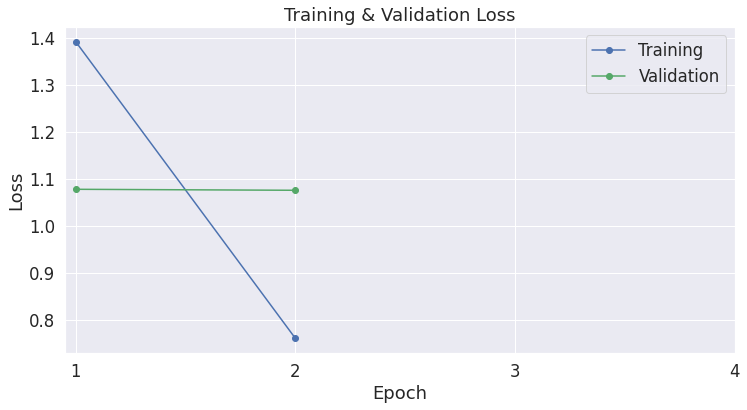

In [ ]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve of loss
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Validation Loss'], 'g-o', label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

**SAVE THE FINETUNED MODEL**

In [ ]:
torch.save(finetuned_model, 'SQuAD_2.0_BERT_model.pt')

In [ ]:
# Create output directory if needed
output_dir = 'BERT_outputs'

if not os.path.exists(output_dir):

    os.makedirs(output_dir)

print('Saving model checkpoint to: ',output_dir)

# Save a trained model, configuration and tokenizer using 'save_pretrained()'.

# They can then be reloaded using 'from_pretrained()'

model_to_save = finetuned_model.module if hasattr(finetuned_model, 'module') else finetuned_model  # Take care of distributed/parallel training

model_to_save.save_pretrained(output_dir)

tokenizer.save_pretrained(output_dir)

Saving model checkpoint to:  BERT_outputs


('BERT_outputs/tokenizer_config.json',
 'BERT_outputs/special_tokens_map.json',
 'BERT_outputs/vocab.txt',
 'BERT_outputs/added_tokens.json',
 'BERT_outputs/tokenizer.json')

**LOAD THE FINETUNED MODEL**

In [ ]:
# In case you want to load to model using the cpu use the command below:
model = torch.load('SQuAD_2.0_BERT_model.pt', map_location=torch.device('cpu'))
model.eval()

# Loading its tokenizer
#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Loading the model
#model = BertForQuestionAnswering.from_pretrained(output_dir).to(device)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

**FUNCTIONS USED FOR MODEL TESTING**

In [ ]:
#=== Data preparation ===

# A function that applies preprocessing steps to a given text (for the context and its predicted answer) 
def normalize_text(text):
  
  # Lower all letters in text
  lowered_text = text.lower()
  
  # Remove punctuation
  exclude = set(string.punctuation)
  no_punct_text = "".join(i for i in lowered_text if i not in exclude)
  
  # Remove the articles
  regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
  no_articles_text = re.sub(regex, " ", no_punct_text)

  # Join the text 
  normalized_text = " ".join(no_articles_text.split())
  
  return normalized_text

In [ ]:
#=== Metric calculation ===

# A function that computes the exact match of the predicted answer and the true answer in the passage
def compute_exact_match(predicted_answer, true_answer):
  
  return int(normalize_text(predicted_answer) == normalize_text(true_answer))


# A function that calculates the precision, recall and the f1 score of the predicted and the true answer in the passage
def compute_metrics(predicted_answer, true_answer):
    
  predicted_tokens = normalize_text(predicted_answer).split()
  true_tokens = normalize_text(true_answer).split()
    
  common_tokens = Counter(true_tokens) & Counter(predicted_tokens)
  numbers_of_same = sum(common_tokens.values())

  # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
  if len(true_tokens) == 0 or len(predicted_tokens) == 0:
    return int(true_tokens == predicted_tokens)

  if numbers_of_same == 0:
    return 0

  precision = 1.0 * numbers_of_same / len(predicted_tokens)
  recall = 1.0 * numbers_of_same / len(true_tokens)
  score_f1 = (2 * precision * recall) / (precision + recall)

  return precision, recall, score_f1 

In [ ]:
# A function that takes an str question and a passage that contains the answer, identifies the words in the passage and gets the answer
def question_answering(question, text):
    
  # ======== Tokenize ========
  # Apply the tokenizer to the input text, treating them as a text-pair
  input_ids = tokenizer.encode(question, text)

  # ======== Set Segment IDs ========
  # Search the input_ids for the first instance of the [SEP] token
  sep_index = input_ids.index(tokenizer.sep_token_id)

  # The number of segment A tokens includes the [SEP] token istelf
  num_seg_a = sep_index + 1

  # The remainder are segment B.
  num_seg_b = len(input_ids) - num_seg_a

  # Construct the list of 0s and 1s.
  segment_ids = [0]*num_seg_a + [1]*num_seg_b

  # There should be a segment_id for every input token
  assert len(segment_ids) == len(input_ids)

  # ======== Evaluate ========
  # Run our example question through the model
                           
  # Pull prediction tensors out and argmax to get predicted tokens  (The tokens representing the input text and the segment IDs to differentiate question from answer_text)
  output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
      
  # ======== Reconstruct Answer ========
  # Find the tokens with the highest start and end scores
  answer_start = torch.argmax(output['start_logits'], dim = 1)
  answer_end = torch.argmax(output['end_logits'], dim = 1)
      
  # Get the string versions of the input tokens
  tokens = tokenizer.convert_ids_to_tokens(input_ids)
  
  # Start with the first token
  answer = tokens[answer_start]

  # Select the remaining answer tokens and join them with whitespace
  for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token
    if tokens[i][0:2] == '##':
      answer += tokens[i][2:]
        
     # Otherwise, add a space then the token
    else:
      answer += ' ' + tokens[i]
  
  Exact_match_score = compute_exact_match(answer, text)
  precision, recall, F1_score = compute_metrics(answer, text)
  
  print('\nQuestion:', question)
  print('\nAnswer: "' + answer + '"')
  print('Exact Match {} | Precision {} | Recall {} | F1 score {}'.format(Exact_match_score, precision, recall, F1_score))
 

**QUESTION ANSWERING: TEST THE BERT MODEL**

In [ ]:
# Wrap text to 100 characters
wrapper = textwrap.TextWrapper(width = 100) 

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

print(wrapper.fill(bert_abstract))

question = "What does BERT stand for?"

question_answering(question, bert_abstract)

We introduce a new language representation model called BERT, which stands for Bidirectional Encoder
Representations from Transformers. Unlike recent language representation models (Peters et al.,
2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from
unlabeled text by jointly conditioning on both left and right context in all layers. As a result,
the pre-trained BERT model can be finetuned with just one additional output layer to create state-
of-the-art models for a wide range of tasks, such as question answering and language inference,
without substantial taskspecific architecture modifications. BERT is conceptually simple and
empirically powerful. It obtains new state-of-the-art results on eleven natural language processing
tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI
accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5
point absolute improvement)

In [ ]:
# Wrap text to 100 characters
wrapper = textwrap.TextWrapper(width = 100) 

question_answering_art_abstract = "Extractive reading comprehension systems can often locate the correct answer to a question in a context document, but they also tend to make unreliable guesses on questions for which the correct answer is not stated in the context. Existing datasets either focus exclusively on answerable questions, or use automatically generated unanswerable questions that are easy to identify. To address these weaknesses, we present SQuAD 2.0, the latest version of the Stanford Question Answering Dataset (SQuAD). SQuAD 2.0 combines existing SQuAD data with over 50,000 unanswerable questions written adversarially by crowdworkers to look similar to answerable ones. To do well on SQuAD 2.0, systems must not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering. SQuAD 2.0 is a challenging natural language understanding task for existing models: a strong neural system that gets 86% F1 on SQuAD 1.1 achieves only 66% F1 on SQuAD 2.0."

print(wrapper.fill(question_answering_art_abstract))

question = "What is SQuAD?"

question_answering(question, question_answering_art_abstract)

Extractive reading comprehension systems can often locate the correct answer to a question in a
context document, but they also tend to make unreliable guesses on questions for which the correct
answer is not stated in the context. Existing datasets either focus exclusively on answerable
questions, or use automatically generated unanswerable questions that are easy to identify. To
address these weaknesses, we present SQuAD 2.0, the latest version of the Stanford Question
Answering Dataset (SQuAD). SQuAD 2.0 combines existing SQuAD data with over 50,000 unanswerable
questions written adversarially by crowdworkers to look similar to answerable ones. To do well on
SQuAD 2.0, systems must not only answer questions when possible, but also determine when no answer
is supported by the paragraph and abstain from answering. SQuAD 2.0 is a challenging natural
language understanding task for existing models: a strong neural system that gets 86% F1 on SQuAD
1.1 achieves only 66% F1 on SQuAD 2.0.



In [ ]:
text = input('Please enter your text without quotation marks: \n')
question = input('\nPlease enter your question without quotation marks: \n')

while True:
  question_answering(question, text)
    
  flag = True
  flag_N = False
    
  while flag:
    response = input("\nDo you want to ask another question based on this text (Y/N)? ")
    if response[0] == "Y":
      question = input("\nPlease enter your question: \n")
      flag = False
    elif response[0] == "N":
      print("\nBye!")
      flag = False
      flag_N = True
            
  if flag_N == True:
    break

KeyboardInterrupt: ignored